# Format Europe energy demand

Data are hourly, country aggregates, from ENTSOE: https://www.entsoe.eu/data/power-stats/

In [1]:
import pandas as pd

In [2]:
data_path = "/g/data/w42/dr6273/work/data/ENTSOE/"

In [3]:
hourly = pd.read_csv(
    data_path+"Monthly-hourly-load-values_2006-2015.csv",
    skiprows=3,
    header=0,
    parse_dates={'timestamp': ['Year','Month', "Day"]},
    index_col="timestamp",
    # usecols=["Date", "Time", "NSW1", "QLD1", "SA1", "TAS1", "VIC1"]
)

### Important!

Some countries don't have the full range of data. E.g. GB starts in 2010, IE in 2008. So, let's average across regions instead of sum.

Sum over hours

In [15]:
daily = hourly[["Country", "Coverage ratio"]]

In [16]:
daily["Unscaled power (MWh/day)"] = hourly.iloc[:,2:].sum(axis=1)

/jobfs/91215371.gadi-pbs/ipykernel_1843439/65306476.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily["Unscaled power (MWh/day)"] = hourly.iloc[:,2:].sum(axis=1)


According to the data, "To get the real value, you need to scale them to 100% for coverage ratio less than 100."

In [17]:
def scale(ratio, value):
    """
    Scale the value to 100% coverage
    
    ratio: coverage ration (%)
    value: value to scale to 100
    """
    return value / (ratio / 100) 

In [18]:
daily["Power (MWh/day)"] = daily.apply(
    lambda x : scale(x['Coverage ratio'], x["Unscaled power (MWh/day)"]), axis=1
)

/jobfs/91215371.gadi-pbs/ipykernel_1843439/2149852256.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily["Power (MWh/day)"] = daily.apply(


In [19]:
daily = daily.drop("Unscaled power (MWh/day)", axis=1)
daily = daily.drop("Coverage ratio", axis=1)

Only keep the following countries: Austria, Belgium, Denmark, France, Germany, Ireland, Italy, Luxembourg, the Netherlands, Norway, Portugal, Spain, Sweden, Switzerland and the UK.

In [20]:
daily["Country"].unique()

array(['AT', 'BA', 'BE', 'BG', 'CH', 'CS', 'CY', 'CZ', 'DE', 'DK', 'DK_W',
       'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IS', 'IT',
       'LT', 'LU', 'LV', 'ME', 'MK', 'NI', 'NL', 'NO', 'PL', 'PT', 'RO',
       'RS', 'SE', 'SI', 'SK', 'UA_W'], dtype=object)

In [21]:
codes = ["AT", "BE", "DK", "FR", "DE", "IE", "IT", "LU", "NL", "NO", "PT", "ES", "SE", "CH", "GB"]
len(codes)

15

In [22]:
daily = daily.loc[daily["Country"].isin(codes)]

Average over all countries

In [23]:
daily = daily.groupby(daily.index).mean()

/jobfs/91215371.gadi-pbs/ipykernel_1843439/590818275.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily = daily.groupby(daily.index).mean()


In [24]:
daily.head()

,Power (MWh/day)
timestamp,
2006-01-01,455934.325181
2006-01-02,555819.017459
2006-01-03,593482.768290
2006-01-04,604355.591557
2006-01-05,612865.788839


<AxesSubplot: xlabel='timestamp'>

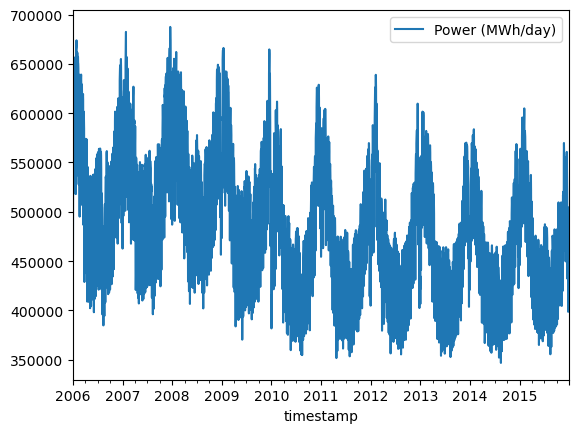

In [25]:
daily.plot()

In [26]:
daily.to_csv(
    data_path+"EU_daily_avg_demand_2006-2015.csv"
)